This kernel work with time series marching learning. We going to pick only google stock price dataset as it is simple and useful for beginner. We use Long Short-Term Memory networks (LSTM) for our prediction. We are going to predict the price of google stock. 

# Import Library

In [190]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("../input"))

['Google_Stock_Price_Train.csv', 'Google_Stock_Price_Test.csv']


# Import Data

In [191]:
stock_data = pd.read_csv("../input/Google_Stock_Price_Train.csv")
test_data = pd.read_csv("../input/Google_Stock_Price_Test.csv")

# Data Exploration

### Sample data

In [192]:
stock_data.head()

,Date,Open,High,Low,Close,Volume
0,26-Sep-17,936.69,944.08,935.12,937.43,1672749
1,25-Sep-17,939.45,939.75,924.51,934.28,1873375
2,22-Sep-17,942.77,950.00,940.84,943.26,1074806
3,21-Sep-17,948.13,952.80,939.38,947.55,1370685
4,20-Sep-17,937.73,950.00,937.50,947.54,2004018


In [193]:
stock_data.tail()

,Date,Open,High,Low,Close,Volume
1253,2-Oct-12,382.98,383.38,375.51,378.87,2790375
1254,1-Oct-12,379.90,382.88,378.48,381.27,3168477
1255,28-Sep-12,377.45,380.03,375.95,377.63,2784091
1256,27-Sep-12,380.35,381.80,376.20,378.63,3932272
1257,26-Sep-12,375.30,381.00,370.87,377.11,5674334


In [194]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
Date      1258 non-null object
Open      1258 non-null float64
High      1258 non-null float64
Low       1258 non-null float64
Close     1258 non-null float64
Volume    1258 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 59.0+ KB


From here we can see our data has 6 columns:
* **Date**: The date of recorded data
* **Open**: The price when stock market open
* **High**: The highest price price of date
* **Low**: The lowest price point of date
* **Volumn**: Total Sale of stock on that date

From this point we going to define our goal is to predict the **close price** of the given date from test data

### Parse and order by date 

As given values of column date is **String** so we will convert it to datetime. After that we order the date column with latest to oldest.

In [195]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data = stock_data.sort_values(by=['Date'], ascending=True).reset_index()

In [196]:
stock_data.head()

,index,Date,Open,High,Low,Close,Volume
0,1257,2012-09-26,375.30,381.00,370.87,377.11,5674334
1,1256,2012-09-27,380.35,381.80,376.20,378.63,3932272
2,1255,2012-09-28,377.45,380.03,375.95,377.63,2784091
3,1254,2012-10-01,379.90,382.88,378.48,381.27,3168477
4,1253,2012-10-02,382.98,383.38,375.51,378.87,2790375


In [197]:
stock_data.tail()

,index,Date,Open,High,Low,Close,Volume
1253,4,2017-09-20,937.73,950.00,937.50,947.54,2004018
1254,3,2017-09-21,948.13,952.80,939.38,947.55,1370685
1255,2,2017-09-22,942.77,950.00,940.84,943.26,1074806
1256,1,2017-09-25,939.45,939.75,924.51,934.28,1873375
1257,0,2017-09-26,936.69,944.08,935.12,937.43,1672749


# Virtaulization

### Plot the Open price

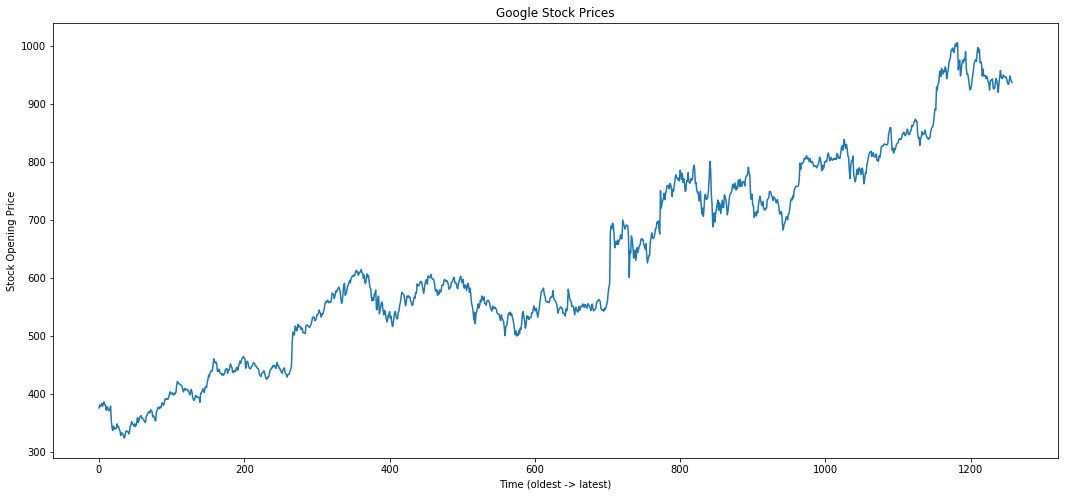

In [198]:
plt.figure(figsize=(18, 8))
plt.plot(stock_data['Open'])
plt.title("Google Stock Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Opening Price")
plt.show()

### Plot the High price

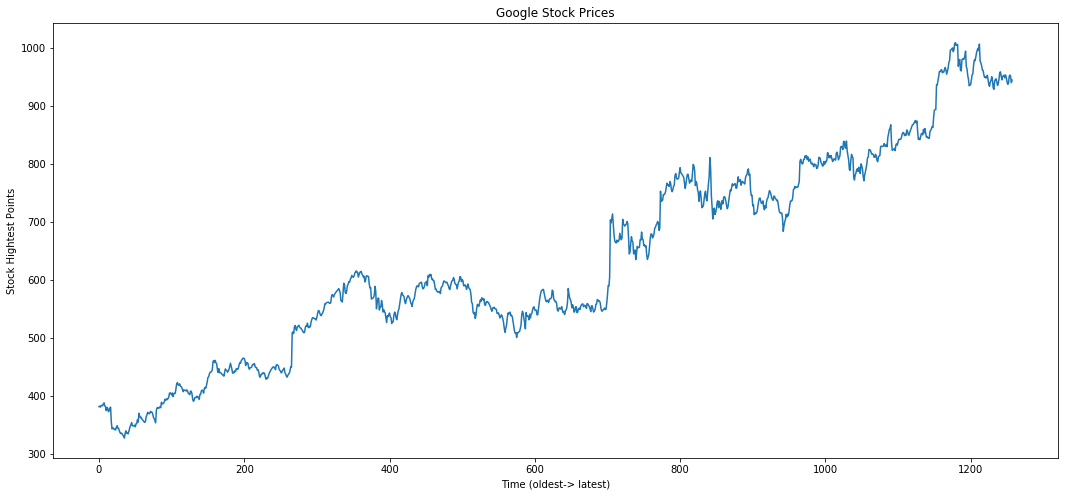

In [199]:
plt.figure(figsize=(18, 8))
plt.plot(stock_data['High'])
plt.title("Google Stock Prices")
plt.xlabel("Time (oldest-> latest)")
plt.ylabel("Stock Hightest Points")
plt.show()

### Plot the Low price

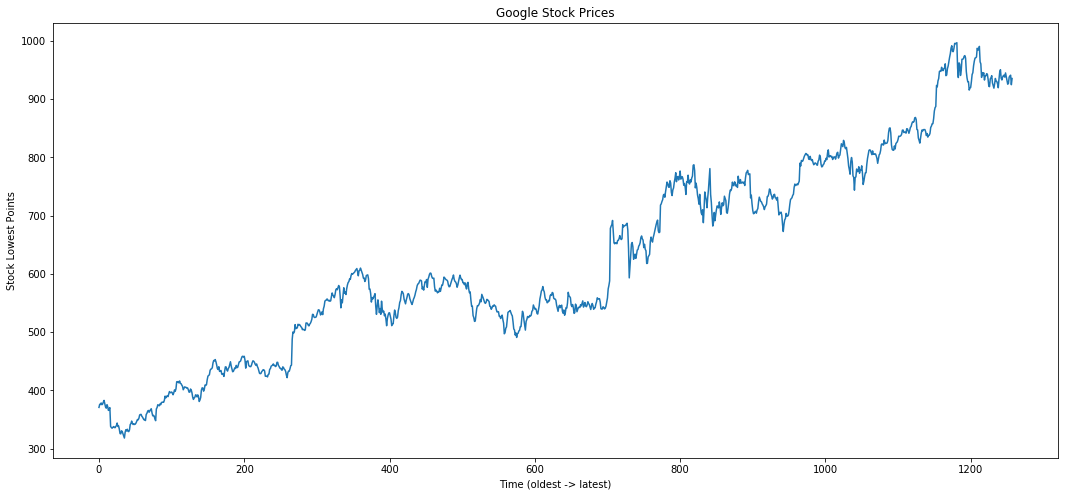

In [200]:
plt.figure(figsize=(18, 8))
plt.plot(stock_data['Low'])
plt.title("Google Stock Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Lowest Points")
plt.show()

From three virtualizations above we can see that google stock price have been increasing it price lately. 

### Plot the volumns sold

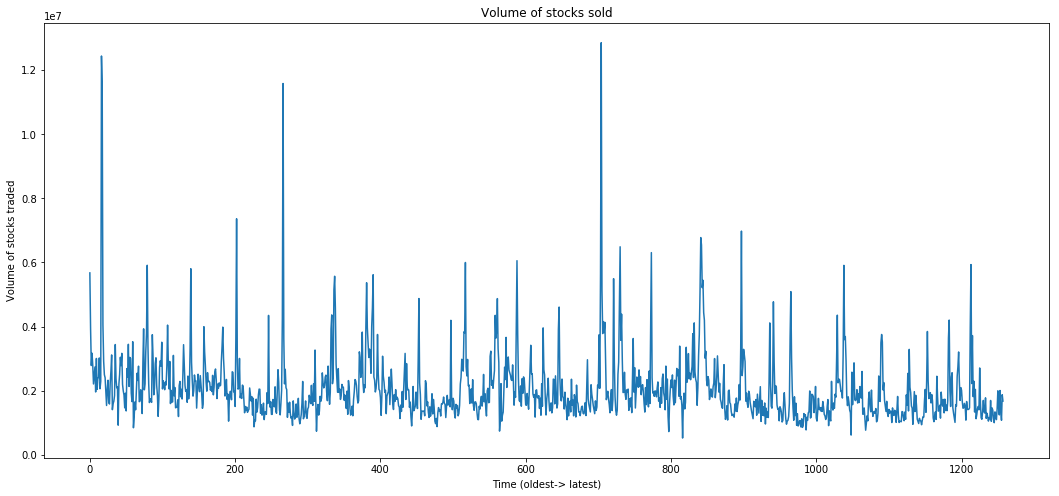

In [201]:
plt.figure(figsize=(18, 8))
plt.plot(stock_data['Volume'])
plt.title("Volume of stocks sold")
plt.xlabel("Time (oldest-> latest)")
plt.ylabel("Volume of stocks traded")
plt.show()

From volumns plot, the volumns sold of google stock bump up base on it season. 

### Select feature
We going to select Open, High, Low, Volumn and Close columns. We will put close column to the last one as it is the target column. 

In [202]:
input_feature = stock_data[['Open', 'High', 'Low', 'Volume', 'Close']]
input_data = input_feature.values

### Normalize data
make data between 0 and 1

In [203]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
input_data[:,:] = scaler.fit_transform(input_data[:,:])

### creating the data to go back for 50 business days in past 

In [204]:
lookback=50
total_size=len(stock_data)
X=[]
y=[]
for i in range(0, total_size-lookback): # loop data set with margin 50 as we use 50 days data for prediction
    t=[]
    for j in range(0, lookback): # loop for 50 days
        current_index = i+j
        t.append(input_data[current_index, :]) # get data margin from 50 days with marging i
    X.append(t)
    y.append(input_data[lookback+i, 4])

### Split train, validate and test data

* We will get last 100 days for testing (predict). 
* We split last remain 10 days to validate our traning
* and the rest will be our training data

In [205]:
test_size=100 # 100 days for testing data
X, y= np.array(X), np.array(y)
X_test = X[:test_size]
Y_test = y[:test_size]

X_work = X[test_size:]
y_work = y[test_size:]

validate_size = 10

X_valid = X[:validate_size]
y_valid = y[:validate_size]
X_train = X[validate_size:]
y_train = y[validate_size:]

### Reshape LSTM input layer

In [206]:
X_train = X_train.reshape(X_train.shape[0], lookback, 5)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, 5)
X_test = X_test.reshape(X_test.shape[0], lookback, 5)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(1198, 50, 5)
(10, 50, 5)
(100, 50, 5)


In [207]:
from keras import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(50, return_sequences= True, activation='relu', input_shape=(X.shape[1], 5)))
model.add(LSTM(50, return_sequences=True, activation='relu'))
model.add(LSTM(50))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 50, 50)            11200     
_________________________________________________________________
lstm_23 (LSTM)               (None, 50, 50)            20200     
_________________________________________________________________
lstm_24 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 51,651
Trainable params: 51,651
Non-trainable params: 0
_________________________________________________________________


# Callbacks
* **EarlyStoping**: It will stop the traning if score of model didn't increase. This prevent model from overfitting. We are to set max in 10 epoches if it didn't increase then we will stop the training
* **ReduceLROnPlateau**: Use for reduce the learning rate. In 3 steps the score didn't increase we will reduce the learning rate to improve the training
* **ModelCheckpoint**: Use for save model only when the score increased

In [208]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

# Compile Model

In [209]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [210]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid), callbacks=callbacks)

Train on 1198 samples, validate on 10 samples
Epoch 1/100
1198/1198 [==============================] - 14s 11ms/step - loss: 0.0494 - acc: 8.3472e-04 - val_loss: 0.0076 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.00756, saving model to model.h5
Epoch 2/100
1198/1198 [==============================] - 8s 7ms/step - loss: 0.0017 - acc: 8.3472e-04 - val_loss: 0.0014 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 0.00756 to 0.00145, saving model to model.h5
Epoch 3/100
1198/1198 [==============================] - 8s 7ms/step - loss: 0.0012 - acc: 8.3472e-04 - val_loss: 5.7531e-04 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 0.00145 to 0.00058, saving model to model.h5
Epoch 4/100
1198/1198 [==============================] - 8s 7ms/step - loss: 0.0011 - acc: 8.3472e-04 - val_loss: 4.9830e-04 - val_acc: 0.0000e+00

Epoch 00004: val_loss improved from 0.00058 to 0.00050, saving model to model.h5
Epoch 5/100
1198/1198 [=========================

# Prediction

In [211]:
predicted_value = model.predict(X_test)

# Virtualize our predicted data

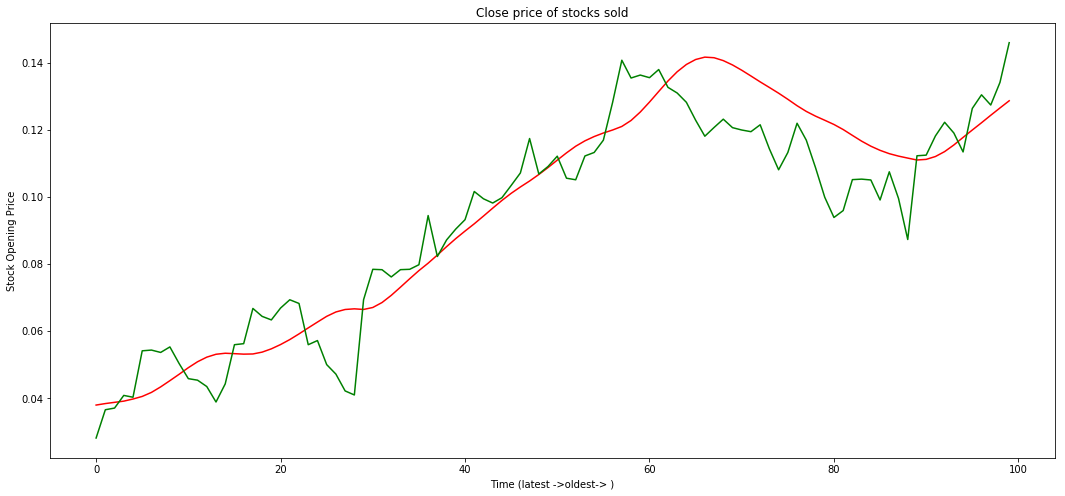

In [212]:
plt.figure(figsize=(18, 8))
plt.plot(predicted_value, color= 'red')
plt.plot(Y_test, color='green')
plt.title("Close price of stocks sold")
plt.xlabel("Time (latest ->oldest-> )")
plt.ylabel("Stock Opening Price")
plt.show()

If you have anything in mind feel free to comment below